In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)


from preprocess.graph import graph_topology_5
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from baselines.transformer import transformer_gate_generator, transformer_gate_generator_1
from models.graph_water_transformer_cov import graph_water_transformer_cov_gate_predictor

from losses.loss import gate_loss, water_level_threshold
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from postprocess.threshold import flood_threshold, drought_threshold, flood_threshold_t1, drought_threshold_t1
from spektral.layers import GCNConv

2023-08-12 17:24:14.948193: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-12 17:24:16.235890: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [4]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


### Graph topology

In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Model

#### Gate & pump predictor

In [7]:
# ===== model parameters ======
input_shape = train_X_mask.shape[1:]
head_size = 64*2
ff_dim = 64
num_transformer_blocks = 1
num_heads = 3
mlp_units = 32
dropout = 0.5
mlp_dropout = 0.3
masked_value = 1e-10
gate_min = 0
gate_max = 1


learning_rate = 5e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 100
EPOCHS = 700
BATCH = 512

In [8]:
gate_predictor = transformer_gate_generator_1(input_shape=input_shape,
                                            head_size=head_size,
                                            num_heads=num_heads,
                                            ff_dim=ff_dim,
                                            num_transformer_blocks=num_transformer_blocks,
                                            mlp_units=mlp_units,
                                            dropout=dropout,
                                            mlp_dropout=mlp_dropout,
                                            masked_value=masked_value,
                                            gate_min=gate_min,
                                            gate_max=gate_max
                                           )
gate_predictor._name = "gate_predictor"
# gate_predictor.summary()

2023-08-12 17:24:29.185523: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1


In [9]:
gate_predictor.compile(optimizer='adam', loss='mse')

#### water stage predictor

In [10]:
ws_predictor = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

for layer in ws_predictor.layers:
    layer.trainable = False

ws_predictor._name = 'ws_predictor'    
# ws_predictor.summary()

#### Combine gate_predictor and trained ws_predictor

In [11]:
inputs_feat = Input(shape=(96, 16), name='inputs_feat')
inputs_tws = Input(shape=(5, 72), name='input_tws')
inputs_adj = Input(shape=(5, 5), name='input_adj')

# ================ gate_predictor ================
gate_predictor_output = gate_predictor(inputs_feat)  # 24*7


# ============  future inputs with replaced gate & pump prediction ============
replaced_future_gate_pump = layers.Concatenate(axis=-1)([inputs_feat[:, n_hours:, :2], 
                                                         gate_predictor_output, 
                                                         inputs_feat[:, n_hours:, 9:]
                                                        ]
                                                       )

# ============ original past inputs + future inputs with replaced gate & pump prediction ============
merged_inputs = layers.Concatenate(axis=1)([inputs_feat[:, :n_hours, :], replaced_future_gate_pump])
merged_inputs_cov = merged_inputs[:, :, :12]

ws_predictor_output = ws_predictor([merged_inputs_cov, inputs_tws, inputs_adj])

filda = Model(inputs=[inputs_feat, inputs_tws, inputs_adj], outputs=[gate_predictor_output, ws_predictor_output], name='filda')
# filda.summary()

Epoch 1/700


2023-08-11 02:38:56.472425: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-11 02:38:57.817411: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ef4694e61e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-11 02:38:57.817466: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-08-11 02:38:57.828070: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-11 02:38:58.239184: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_ws_predictor_loss improved from inf to 2.41495, saving model to ../saved_models/transformer_gtnp_1.h5
151/151 - 25s - loss: 0.4866 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2433 - val_loss: 4.8299 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.4149 - 25s/epoch - 164ms/step
Epoch 2/700


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_ws_predictor_loss improved from 2.41495 to 1.93656, saving model to ../saved_models/transformer_gtnp_1.h5
151/151 - 11s - loss: 0.4618 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2309 - val_loss: 3.8731 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.9366 - 11s/epoch - 75ms/step
Epoch 3/700

Epoch 3: val_ws_predictor_loss did not improve from 1.93656
151/151 - 11s - loss: 0.4547 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2274 - val_loss: 3.9675 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.9838 - 11s/epoch - 75ms/step
Epoch 4/700

Epoch 4: val_ws_predictor_loss improved from 1.93656 to 1.88610, saving model to ../saved_models/transformer_gtnp_1.h5
151/151 - 11s - loss: 0.4525 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2263 - val_loss: 3.7722 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.8861 - 11s/epoch - 75ms/step
Epoch 5/700

Epoch 5: val_ws_predictor_loss did not improve fro

151/151 - 11s - loss: 0.4329 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2164 - val_loss: 3.5012 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.7506 - 11s/epoch - 74ms/step
Epoch 30/700

Epoch 30: val_ws_predictor_loss did not improve from 1.74856
151/151 - 11s - loss: 0.4329 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2164 - val_loss: 3.5005 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.7502 - 11s/epoch - 74ms/step
Epoch 31/700

Epoch 31: val_ws_predictor_loss did not improve from 1.74856
151/151 - 11s - loss: 0.4327 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2163 - val_loss: 3.5001 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.7501 - 11s/epoch - 74ms/step
Epoch 32/700

Epoch 32: val_ws_predictor_loss did not improve from 1.74856
151/151 - 11s - loss: 0.4326 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2163 - val_loss: 3.4999 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predic

Epoch 59/700

Epoch 59: val_ws_predictor_loss did not improve from 1.74856
151/151 - 11s - loss: 0.4314 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2157 - val_loss: 3.5012 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.7506 - 11s/epoch - 74ms/step
Epoch 60/700

Epoch 60: val_ws_predictor_loss did not improve from 1.74856
151/151 - 11s - loss: 0.4314 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2157 - val_loss: 3.5049 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.7524 - 11s/epoch - 74ms/step
Epoch 61/700

Epoch 61: val_ws_predictor_loss did not improve from 1.74856
151/151 - 11s - loss: 0.4314 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2157 - val_loss: 3.5069 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.7535 - 11s/epoch - 74ms/step
Epoch 62/700

Epoch 62: val_ws_predictor_loss did not improve from 1.74856
151/151 - 11s - loss: 0.4314 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.21

Epoch 89/700

Epoch 89: val_ws_predictor_loss did not improve from 1.74856
151/151 - 11s - loss: 0.4313 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2156 - val_loss: 3.5018 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.7509 - 11s/epoch - 74ms/step
Epoch 90/700

Epoch 90: val_ws_predictor_loss did not improve from 1.74856
151/151 - 11s - loss: 0.4312 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2156 - val_loss: 3.5098 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.7549 - 11s/epoch - 74ms/step
Epoch 91/700

Epoch 91: val_ws_predictor_loss did not improve from 1.74856
151/151 - 11s - loss: 0.4312 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2156 - val_loss: 3.5072 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.7536 - 11s/epoch - 74ms/step
Epoch 92/700

Epoch 92: val_ws_predictor_loss did not improve from 1.74856
151/151 - 11s - loss: 0.4309 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.21

151/151 - 11s - loss: 0.4309 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2155 - val_loss: 3.5084 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.7542 - 11s/epoch - 74ms/step
Epoch 119/700

Epoch 119: val_ws_predictor_loss did not improve from 1.74856
151/151 - 11s - loss: 0.4309 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2155 - val_loss: 3.5033 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.7516 - 11s/epoch - 74ms/step
Epoch 120/700

Epoch 120: val_ws_predictor_loss did not improve from 1.74856
151/151 - 11s - loss: 0.4309 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2155 - val_loss: 3.5040 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.7520 - 11s/epoch - 74ms/step
Epoch 121/700

Epoch 121: val_ws_predictor_loss did not improve from 1.74856
151/151 - 11s - loss: 0.4308 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2154 - val_loss: 3.5067 - val_gate_predictor_loss: 0.0000e+00 - val_ws_

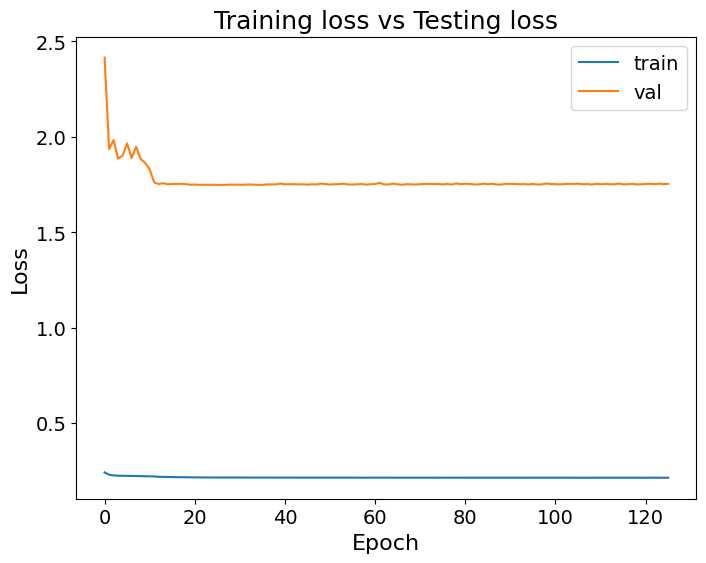

In [12]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

filda.compile(optimizer=Adam(learning_rate=lr_schedule),
             loss=[gate_loss, water_level_threshold], 
             loss_weights=[0.0, 2.0]
            )


es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=100)
mc = ModelCheckpoint('../saved_models/transformer_gtnp_1.h5'.format(n_hours, K),
                     monitor='val_ws_predictor_loss',
                     mode='min',
                     verbose=2, 
                     custom_objects={'gate_loss':gate_loss, 'water_level_threshold':water_level_threshold}, 
                     save_best_only=True)


history = filda.fit([train_X_mask, train_tws_reshape, train_adj_mat], [train_gate_pump_y, train_ws_y],
                   validation_data=([val_X_mask, val_tws_reshape, val_adj_mat], [val_gate_pump_y, val_ws_y]),
                   batch_size=BATCH, 
                   epochs=EPOCHS, 
                   verbose=2, 
                   callbacks=[es, mc],
                   shuffle=True,

                  )


plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['ws_predictor_loss'], label='train')
plt.plot(history.history['val_ws_predictor_loss'], label='val')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [12]:
saved_model = load_model('../saved_models/transformer_gtnp_1.h5',
                         custom_objects={'gate_loss':gate_loss, 
                                         'water_level_threshold':water_level_threshold,
                                         'GCNConv': GCNConv
                                        }
                        )

In [13]:
start_time = time.perf_counter()


gate_pump_pred, ws_pred = saved_model.predict([test_X_mask, test_tws_reshape, test_adj_mat])

print(gate_pump_pred.shape)
print(ws_pred.shape)


end_time = time.perf_counter()
used_time = end_time - start_time
print(f"Usded time: {used_time} seconds")

2023-08-12 17:24:42.903369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


603/603 [==============================] - 5s 6ms/step
(19268, 24, 7)
(19268, 96)
Usded time: 6.765011740848422 seconds


#### ws pred, gate pred

In [15]:
ws_pred_gate_pred_inv = ws_scaler.inverse_transform(ws_pred)
ws_pred_gate_pred_inv = ws_pred_gate_pred_inv.reshape((-1, K, 4))
ws_pred_gate_pred_inv.shape

(19268, 24, 4)

#### ws true, gate true

In [16]:
ws_true_gate_true = test_ws_y
ws_true_gate_true_inv = ws_scaler.inverse_transform(ws_true_gate_true)
ws_true_gate_true_inv = ws_true_gate_true_inv.reshape((-1, K, 4))
ws_true_gate_true_inv.shape

(19268, 24, 4)

#### ws pred, gate true

In [17]:
ws_predictor = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

ws_pred_gate_true = ws_predictor.predict([test_cov, test_tws_reshape, test_adj_mat])
ws_pred_gate_true_inv = ws_scaler.inverse_transform(ws_pred_gate_true)
ws_pred_gate_true_inv = ws_pred_gate_true_inv.reshape((-1, 24, 4))
ws_pred_gate_true_inv.shape

603/603 [==============================] - 2s 3ms/step


(19268, 24, 4)

### Upper threshould

In [18]:
upper_threshold = 3.5
t1 = 1

flood_threshold_t1(ws_true_gate_true_inv, t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_true_inv, t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_pred_inv, t1, upper_threshold)

S1, S25A, S25B, S26 time steps: 96, 96, 118, 117
S1, S25A, S25B, S26 areas: 14.82, 15.22, 18, 20.13
TOTAL time steps: 427; TOTAL areas: 68.61
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 85, 85, 96, 108
S1, S25A, S25B, S26 areas: 11.5466, 12.1773, 13, 17.2181
TOTAL time steps: 374; TOTAL areas: 54.3063
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 85, 85, 96, 108
S1, S25A, S25B, S26 areas: 11.5466, 12.1773, 13, 17.2181
TOTAL time steps: 374; TOTAL areas: 54.3063
--------------------------------------------------


In [19]:
flood_threshold_t1(ws_true_gate_true_inv[7640-23:7680-23], t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_true_inv[7640-23:7680-23], t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_pred_inv[7640-23:7680-23], t1, upper_threshold)

S1, S25A, S25B, S26 time steps: 6, 5, 6, 6
S1, S25A, S25B, S26 areas: 0.84, 0.72, 1, 1.0
TOTAL time steps: 23; TOTAL areas: 3.62
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 6, 6, 5, 5
S1, S25A, S25B, S26 areas: 0.6148, 0.6425, 1, 0.8663
TOTAL time steps: 22; TOTAL areas: 3.0018
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 6, 6, 5, 5
S1, S25A, S25B, S26 areas: 0.6148, 0.6425, 1, 0.8663
TOTAL time steps: 22; TOTAL areas: 3.0018
--------------------------------------------------


In [20]:
flood_threshold(ws_true_gate_true_inv, upper_threshold)
flood_threshold(ws_pred_gate_true_inv, upper_threshold)
flood_threshold(ws_pred_gate_pred_inv, upper_threshold)

time steps: 10248, areas: 1646.6399002075195
time steps: 12130, areas: 2088.0380942821503
time steps: 12130, areas: 2088.0380942821503


### Lower threshold

In [21]:
lower_threshold = 0
t1 = 1

drought_threshold_t1(ws_true_gate_true_inv, t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_true_inv, t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_pred_inv, t1, lower_threshold)

S1, S25A, S25B, S26 time steps: 1346, 1341, 1229, 1250
S1, S25A, S25B, S26 areas: -385.8, -383.38, -345.08, -350.84:
TOTAL time steps: 5166; TOTAL areas: -1465.1
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 1390, 1427, 1282, 1476
S1, S25A, S25B, S26 areas: -398.849, -392.0414, -350.2885, -429.5386:
TOTAL time steps: 5575; TOTAL areas: -1570.7176
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 1180, 1062, 937, 1199
S1, S25A, S25B, S26 areas: -310.1655, -271.6843, -240.3643, -320.7746:
TOTAL time steps: 4378; TOTAL areas: -1142.9887
--------------------------------------------------


In [23]:
drought_threshold_t1(ws_true_gate_true_inv[7640-23:7680-23], t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_true_inv[7640-23:7680-23], t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_pred_inv[7640-23:7680-23], t1, lower_threshold)

S1, S25A, S25B, S26 time steps: 0, 0, 0, 0
S1, S25A, S25B, S26 areas: 0, 0, 0, 0:
TOTAL time steps: 0; TOTAL areas: 0
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 0, 0, 0, 0
S1, S25A, S25B, S26 areas: 0, 0, 0, 0:
TOTAL time steps: 0; TOTAL areas: 0
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 0, 0, 0, 0
S1, S25A, S25B, S26 areas: 0, 0, 0, 0:
TOTAL time steps: 0; TOTAL areas: 0
--------------------------------------------------


In [22]:
lower_threshold = 0

drought_threshold(ws_true_gate_true_inv, lower_threshold)
drought_threshold(ws_pred_gate_true_inv, lower_threshold)
drought_threshold(ws_pred_gate_pred_inv, lower_threshold)

time steps: 124148, areas: 35182.6098122485
time steps: 127126, areas: 34960.07284716559
time steps: 91815, areas: 23486.057383245246
